# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = "traffic-signs-data/train.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


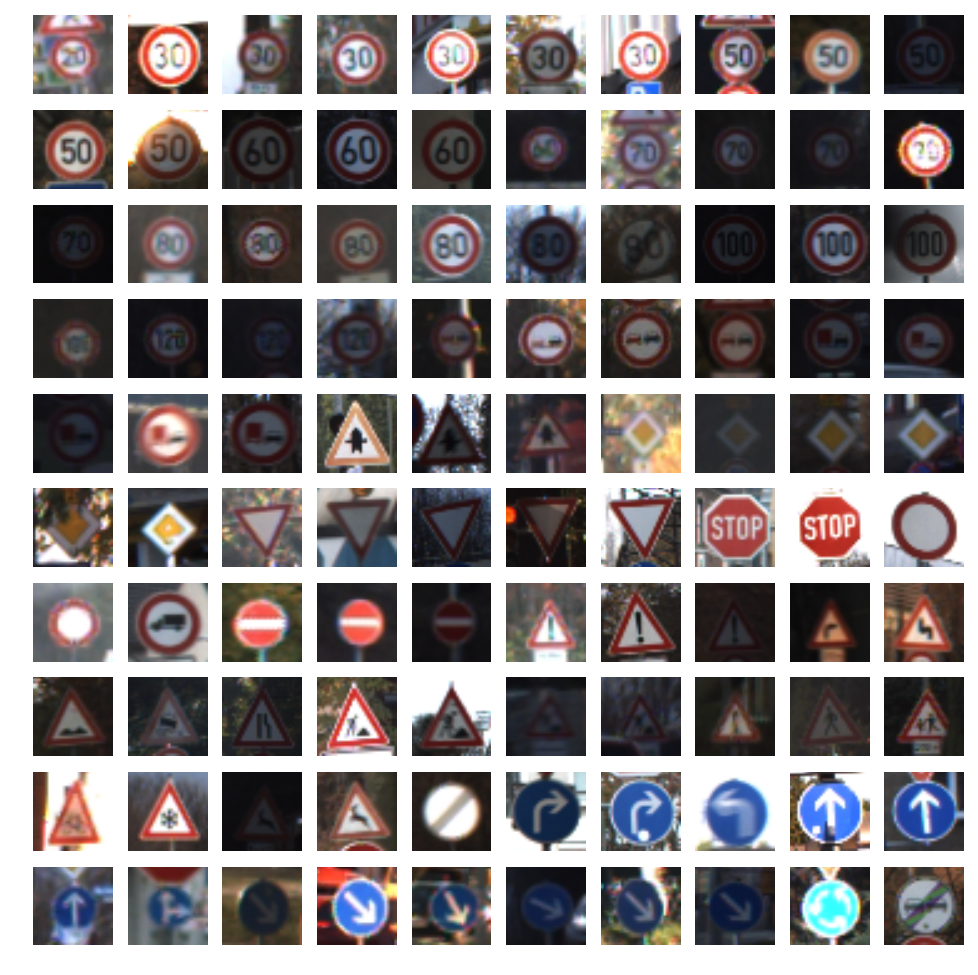

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

gs1 = gridspec.GridSpec(10, 10)
gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 
plt.figure(figsize=(12,12))
d = round(len(X_train)/100)
for i in range(100):
    ax1 = plt.subplot(gs1[i])
    #ax1.set_xticklabels([])
    #ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    plt.subplot(10,10,i+1)
    plt.imshow(X_train[i*d])
    plt.axis('off')

plt.show()

The original images contain one traffic sign each. Images contain a border of 10 % around the actual traffic sign (at least 5 pixels) to allow for edge-based approaches. They are stored in PPM format (Portable Pixmap, P6). Since image sizes vary between 15x15 to 250x250 pixels, we need resize them with the same size. The corresponding annotations provide the boounding box of the traffic signs. So, we capture the region and create new features. We compare orginal images and the regions with the accuracy later.

Each resized image is 32 pixels by 32 pixels. We can interpret this as a big array of numbers. We can flatten this array into a vector of 32x32 = 1024 numbers. It doesn't matter how we flatten the array, as long as we're consistent between images. From this perspective, the traffic sign images are just a bunch of points in a 784-dimensional vector space. The result is that train images is a tensor (an n-dimensional array) with a shape of [39209, 1024]. The first dimension is an index into the list of images and the second dimension is the index for each pixel in each image. Each entry in the tensor is a pixel intensity between 0 and 1, for a particular pixel in a particular image.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
from skimage.transform import resize

# 1. Greyscale features
import cv2
def greyscale(image):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(img, cmap='gray')"""
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def greyscale_features(X_data):
    features = []
    for n in range(len(X_data)):
        greyed_feature = greyscale(X_data[n]) # convert RGB to Gray
        features.append(greyed_feature)
    return features

In [5]:
train_features = greyscale_features(X_train)
test_features = greyscale_features(X_test)

In [6]:
# 2. Normalize features
import numpy as np

def cv2normalize(image):
    dst = np.zeros(image.shape)
    cv2.normalize(image, dst, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return dst

def normalize(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = 0.1
    b = 0.9
    greyscale_min = 0
    greyscale_max = 255
    return a + ( (image_data - greyscale_min) * (b - a) )/ ( greyscale_max - greyscale_min ) 

    norm_data = []
    for n in range(len(image_data)):
        normalized = cv2normalize(image_data[n])
        norm_data.append(normalized)
    return norm_data

In [7]:
norm_train_dataset = normalize(np.array(train_features))
norm_test_dataset = normalize(np.array(test_features))
train_dataset = norm_train_dataset.astype(np.float32)
test_dataset = norm_test_dataset.astype(np.float32)
is_features_normal = True
print('Features Normalized!')

Features Normalized!


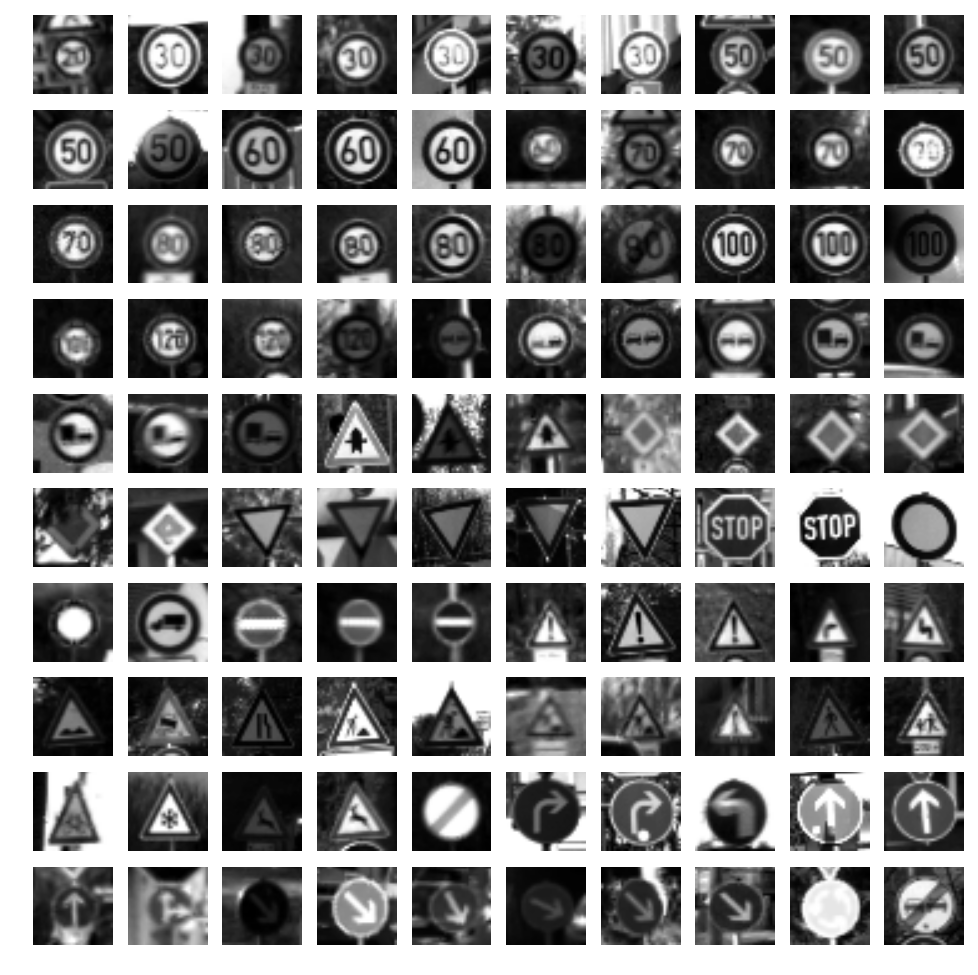

In [8]:
gs1 = gridspec.GridSpec(10, 10)
gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 
plt.figure(figsize=(12,12))
d = round(len(X_train)/100)
for i in range(100):
    ax1 = plt.subplot(gs1[i])
    #ax1.set_xticklabels([])
    #ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    plt.subplot(10,10,i+1)
    plt.imshow(norm_train_dataset[i*d], cmap='gray')
    plt.axis('off')
plt.show()

In [9]:
# 3. Turn labels into numbers and apply One-Hot Encoding
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
encoder.fit(y_train)
train_labels = encoder.transform(y_train)
test_labels = encoder.transform(y_test)

# Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
train_labels = train_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)
is_labels_encod = True

print('Labels One-Hot Encoded')

Labels One-Hot Encoded


In [10]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
# Get randomized datasets for training and validation
from sklearn.model_selection import train_test_split

train_dataset, valid_dataset, train_labels, valid_labels = train_test_split(
    train_dataset,
    train_labels,
    test_size=0.05,
    random_state=832289)

In [11]:
print('Features and labels randomized and split into train/validation ones, respectively.')
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Features and labels randomized and split into train/validation ones, respectively.
Training set (37248, 32, 32) (37248, 43)
Validation set (1961, 32, 32) (1961, 43)
Test set (12630, 32, 32) (12630, 43)


In [12]:
# Save the data for easy access
import os

pickle_file = 'trafficSigns.pkl'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open(pickle_file, 'wb') as pfile:
            pickle.dump(
                {
                    'train_dataset': train_dataset,
                    'train_labels': train_labels,
                    'valid_dataset': valid_dataset,
                    'valid_labels': valid_labels,
                    'test_dataset': test_dataset,
                    'test_labels': test_labels,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

is_features_labels_dump = True
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', norm_test_dataset.shape, test_labels.shape)

print('Data cached in pickle file.')

Training set (37248, 32, 32) (37248, 43)
Validation set (1961, 32, 32) (1961, 43)
Test set (12630, 32, 32) (12630, 43)
Data cached in pickle file.


#### Checkpoint
All our progress is now saved to the pickle file.  If we need to leave and comeback to this lab, we no longer have to start from the beginning.  Just run the code block below and it will load all the data and modules required to proceed.

In [13]:
%matplotlib inline

# Load the modules
import pickle
import math

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt



# Reload the data
pickle_file = 'trafficSigns.pkl'
with open(pickle_file, 'rb') as f:
    pickle_data = pickle.load(f)
    train_dataset = pickle_data['train_dataset']
    train_labels = pickle_data['train_labels']
    valid_dataset = pickle_data['valid_dataset']
    valid_labels = pickle_data['valid_labels']
    test_dataset = pickle_data['test_dataset']
    test_labels = pickle_data['test_labels']
    del pickle_data  # Free up memory
    
    is_features_labels_dump = True
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

train_dataset = train_dataset.astype(np.float32)
valid_dataset = valid_dataset.astype(np.float32)
test_dataset = test_dataset.astype(np.float32)
train_labels = train_labels.astype(np.float32)
valid_labels = valid_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)

Training set (37248, 32, 32) (37248, 43)
Validation set (1961, 32, 32) (1961, 43)
Test set (12630, 32, 32) (12630, 43)


In [14]:
import numpy as np

image_size = train_dataset.shape[1]
num_labels = len(train_labels[0])
num_channels = 1 # grayscale

def reformat(dataset, labels):
    dataset = dataset.reshape(
        (-1, image_size, image_size, num_channels)).astype(np.float32)
    #labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (37248, 32, 32, 1) (37248, 43)
Validation set (1961, 32, 32, 1) (1961, 43)
Test set (12630, 32, 32, 1) (12630, 43)


In [15]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

In [16]:
# hyperparamters
batch_size = 42
patch_size = 5
depth = 16
num_hidden = 64
epochs = 100
learning_rate = 0.01

In [17]:
import tensorflow as tf
graph = tf.Graph()

# This variable won't be stored, since it is declared after tf.train.Saver()
with graph.as_default():
    # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))#tf.constant(test_dataset)
  
    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, num_channels, depth], stddev=0.1), name='layer1_weights')
    layer1_biases = tf.Variable(tf.zeros([depth]), name='layer1_biases')
    layer2_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, depth, depth], stddev=0.1), name='layer2_weights')
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]), name='layer2_biases')
    layer3_weights = tf.Variable(tf.truncated_normal(
            [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1), name='layer3_weights')
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]), name='layer3_biases')
    layer4_weights = tf.Variable(tf.truncated_normal(
            [num_hidden, num_labels], stddev=0.1), name='layer4_weights')
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='layer4_biases')
  
    # Model.
    def model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        #pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        #pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases
  
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

    # [Save&Restore:begin]
    ckpt_dir = "./ckpt_dir"
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)
    global_step = tf.Variable(0, name='global_step', trainable=False)
    # Call this after declaring all tf.Variables.
    saver = tf.train.Saver()
    # [Save&Restore:end]

    init = tf.global_variables_initializer()

In [18]:
from sklearn.utils import shuffle

log_batch_step = round(train_dataset.shape[0]/valid_dataset.shape[0])
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []
test_acc_batch = []

with tf.Session(graph=graph) as sess:
    sess.run(init)
    print('Initialized')
    
    # [Save&Restore:begin]
    # restore all variables
    ckpt = tf.train.get_checkpoint_state(ckpt_dir)
    if ckpt and ckpt.model_checkpoint_path:
        print(ckpt.model_checkpoint_path)
        saver.restore(sess, ckpt.model_checkpoint_path)
    # get last global_step
    #start = global_step.eval(session=sess) 
    start = global_step.eval()
    print("Start from:", start)
    # [Save&Restore:end]
    
    batch_count = int(math.ceil(len(train_dataset)/batch_size))

    for epoch_i in range(start, epochs):
        train_dataset, train_labels = shuffle(train_dataset, train_labels)
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            offset = (batch_i * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = sess.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (batch_i % log_batch_step == 0):
                training_accuracy = accuracy(predictions, batch_labels)
                validation_accuracy = accuracy(valid_prediction.eval(), valid_labels)
                
                # Log batches
                previous_batch = batches[-1] if batches else 0
                batches.append(log_batch_step + previous_batch)
                loss_batch.append(l)
                train_acc_batch.append(training_accuracy)
                valid_acc_batch.append(validation_accuracy)
                
                if not (batch_i % train_dataset.shape[0]):
                    print('Minibatch loss at step %d: %f' % (batch_i, l))
                    print('Minibatch accuracy: %.1f%%' % training_accuracy)
                    print('Validation accuracy: %.1f%%' % validation_accuracy)
        
        # [Save&Restore:begin]
        # set and update(eval) global_step with index, i
        global_step.assign(epoch_i).eval() 
        # save snapshot of all variables at the global step
        saver.save(sess, ckpt_dir + "/model.ckpt", global_step=global_step)
        # [Save&Restore:end]
    sess.close()

Initialized
Start from: 0


Epoch  1/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 5.087290
Minibatch accuracy: 0.0%
Validation accuracy: 0.8%


Epoch  2/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 2.842968
Minibatch accuracy: 38.1%
Validation accuracy: 28.6%


Epoch  3/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 1.451813
Minibatch accuracy: 59.5%
Validation accuracy: 58.5%


Epoch  4/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.886299
Minibatch accuracy: 83.3%
Validation accuracy: 74.6%


Epoch  5/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.643171
Minibatch accuracy: 85.7%
Validation accuracy: 81.6%


Epoch  6/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.503597
Minibatch accuracy: 88.1%
Validation accuracy: 84.7%


Epoch  7/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.416491
Minibatch accuracy: 90.5%
Validation accuracy: 87.5%


Epoch  8/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.346798
Minibatch accuracy: 92.9%
Validation accuracy: 89.1%


Epoch  9/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.290098
Minibatch accuracy: 92.9%
Validation accuracy: 90.2%


Epoch 10/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.234519
Minibatch accuracy: 95.2%
Validation accuracy: 90.8%


Epoch 11/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.202453
Minibatch accuracy: 95.2%
Validation accuracy: 91.8%


Epoch 12/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.175821
Minibatch accuracy: 95.2%
Validation accuracy: 92.0%


Epoch 13/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.159548
Minibatch accuracy: 97.6%
Validation accuracy: 92.2%


Epoch 14/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.143366
Minibatch accuracy: 97.6%
Validation accuracy: 92.7%


Epoch 15/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.125421
Minibatch accuracy: 97.6%
Validation accuracy: 92.9%


Epoch 16/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.110979
Minibatch accuracy: 97.6%
Validation accuracy: 93.3%


Epoch 17/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.102129
Minibatch accuracy: 97.6%
Validation accuracy: 93.6%


Epoch 18/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.098216
Minibatch accuracy: 97.6%
Validation accuracy: 93.5%


Epoch 19/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.093135
Minibatch accuracy: 97.6%
Validation accuracy: 93.9%


Epoch 20/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.086489
Minibatch accuracy: 100.0%
Validation accuracy: 94.4%


Epoch 21/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.085619
Minibatch accuracy: 97.6%
Validation accuracy: 94.4%


Epoch 22/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.080192
Minibatch accuracy: 100.0%
Validation accuracy: 94.6%


Epoch 23/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.071489
Minibatch accuracy: 100.0%
Validation accuracy: 94.7%


Epoch 24/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.071885
Minibatch accuracy: 100.0%
Validation accuracy: 94.7%


Epoch 25/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.064927
Minibatch accuracy: 100.0%
Validation accuracy: 94.9%


Epoch 26/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.061804
Minibatch accuracy: 100.0%
Validation accuracy: 95.0%


Epoch 27/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.060981
Minibatch accuracy: 100.0%
Validation accuracy: 95.2%


Epoch 28/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.060709
Minibatch accuracy: 100.0%
Validation accuracy: 95.4%


Epoch 29/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.055048
Minibatch accuracy: 100.0%
Validation accuracy: 95.3%


Epoch 30/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.055069
Minibatch accuracy: 100.0%
Validation accuracy: 95.5%


Epoch 31/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.051781
Minibatch accuracy: 100.0%
Validation accuracy: 95.7%


Epoch 32/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.045722
Minibatch accuracy: 100.0%
Validation accuracy: 95.8%


Epoch 33/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.042547
Minibatch accuracy: 100.0%
Validation accuracy: 95.8%


Epoch 34/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.039950
Minibatch accuracy: 100.0%
Validation accuracy: 95.9%


Epoch 35/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.036833
Minibatch accuracy: 100.0%
Validation accuracy: 96.0%


Epoch 36/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.033823
Minibatch accuracy: 100.0%
Validation accuracy: 96.0%


Epoch 37/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.033443
Minibatch accuracy: 100.0%
Validation accuracy: 96.2%


Epoch 38/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.030856
Minibatch accuracy: 100.0%
Validation accuracy: 96.2%


Epoch 39/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.027902
Minibatch accuracy: 100.0%
Validation accuracy: 96.1%


Epoch 40/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.026562
Minibatch accuracy: 100.0%
Validation accuracy: 96.3%


Epoch 41/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.025478
Minibatch accuracy: 100.0%
Validation accuracy: 96.4%


Epoch 42/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.023693
Minibatch accuracy: 100.0%
Validation accuracy: 96.3%


Epoch 43/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.022240
Minibatch accuracy: 100.0%
Validation accuracy: 96.4%


Epoch 44/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.020788
Minibatch accuracy: 100.0%
Validation accuracy: 96.3%


Epoch 45/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.019692
Minibatch accuracy: 100.0%
Validation accuracy: 96.3%


Epoch 46/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.018673
Minibatch accuracy: 100.0%
Validation accuracy: 96.2%


Epoch 47/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.017912
Minibatch accuracy: 100.0%
Validation accuracy: 96.3%


Epoch 48/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.016928
Minibatch accuracy: 100.0%
Validation accuracy: 96.2%


Epoch 49/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.016316
Minibatch accuracy: 100.0%
Validation accuracy: 96.2%


Epoch 50/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.015430
Minibatch accuracy: 100.0%
Validation accuracy: 96.1%


Epoch 51/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.015388
Minibatch accuracy: 100.0%
Validation accuracy: 96.2%


Epoch 52/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.014502
Minibatch accuracy: 100.0%
Validation accuracy: 96.1%


Epoch 53/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.014024
Minibatch accuracy: 100.0%
Validation accuracy: 96.1%


Epoch 54/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.013702
Minibatch accuracy: 100.0%
Validation accuracy: 96.1%


Epoch 55/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.013114
Minibatch accuracy: 100.0%
Validation accuracy: 96.2%


Epoch 56/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.012742
Minibatch accuracy: 100.0%
Validation accuracy: 96.1%


Epoch 57/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.012219
Minibatch accuracy: 100.0%
Validation accuracy: 96.1%


Epoch 58/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.011730
Minibatch accuracy: 100.0%
Validation accuracy: 96.2%


Epoch 59/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.011138
Minibatch accuracy: 100.0%
Validation accuracy: 96.2%


Epoch 60/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.010956
Minibatch accuracy: 100.0%
Validation accuracy: 96.1%


Epoch 61/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.010453
Minibatch accuracy: 100.0%
Validation accuracy: 96.1%


Epoch 62/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.010175
Minibatch accuracy: 100.0%
Validation accuracy: 96.1%


Epoch 63/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.009872
Minibatch accuracy: 100.0%
Validation accuracy: 96.2%


Epoch 64/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.009405
Minibatch accuracy: 100.0%
Validation accuracy: 96.2%


Epoch 65/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.008927
Minibatch accuracy: 100.0%
Validation accuracy: 96.1%


Epoch 66/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.008853
Minibatch accuracy: 100.0%
Validation accuracy: 96.3%


Epoch 67/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.008627
Minibatch accuracy: 100.0%
Validation accuracy: 96.2%


Epoch 68/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.008179
Minibatch accuracy: 100.0%
Validation accuracy: 96.2%


Epoch 69/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.008041
Minibatch accuracy: 100.0%
Validation accuracy: 96.2%


Epoch 70/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.007832
Minibatch accuracy: 100.0%
Validation accuracy: 96.2%


Epoch 71/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.007500
Minibatch accuracy: 100.0%
Validation accuracy: 96.1%


Epoch 72/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.007274
Minibatch accuracy: 100.0%
Validation accuracy: 96.2%


Epoch 73/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.007079
Minibatch accuracy: 100.0%
Validation accuracy: 96.2%


Epoch 74/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.006799
Minibatch accuracy: 100.0%
Validation accuracy: 96.3%


Epoch 75/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.006451
Minibatch accuracy: 100.0%
Validation accuracy: 96.3%


Epoch 76/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.006357
Minibatch accuracy: 100.0%
Validation accuracy: 96.3%


Epoch 77/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.006214
Minibatch accuracy: 100.0%
Validation accuracy: 96.3%


Epoch 78/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.005865
Minibatch accuracy: 100.0%
Validation accuracy: 96.4%


Epoch 79/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.005759
Minibatch accuracy: 100.0%
Validation accuracy: 96.4%


Epoch 80/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.005603
Minibatch accuracy: 100.0%
Validation accuracy: 96.4%


Epoch 81/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.005399
Minibatch accuracy: 100.0%
Validation accuracy: 96.4%


Epoch 82/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.005184
Minibatch accuracy: 100.0%
Validation accuracy: 96.4%


Epoch 83/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.005047
Minibatch accuracy: 100.0%
Validation accuracy: 96.4%


Epoch 84/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.004923
Minibatch accuracy: 100.0%
Validation accuracy: 96.4%


Epoch 85/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.004735
Minibatch accuracy: 100.0%
Validation accuracy: 96.4%


Epoch 86/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.004634
Minibatch accuracy: 100.0%
Validation accuracy: 96.4%


Epoch 87/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.004529
Minibatch accuracy: 100.0%
Validation accuracy: 96.4%


Epoch 88/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.004395
Minibatch accuracy: 100.0%
Validation accuracy: 96.5%


Epoch 89/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.004221
Minibatch accuracy: 100.0%
Validation accuracy: 96.5%


Epoch 90/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.004169
Minibatch accuracy: 100.0%
Validation accuracy: 96.5%


Epoch 91/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.003983
Minibatch accuracy: 100.0%
Validation accuracy: 96.5%


Epoch 92/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.003937
Minibatch accuracy: 100.0%
Validation accuracy: 96.5%


Epoch 93/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.003807
Minibatch accuracy: 100.0%
Validation accuracy: 96.5%


Epoch 94/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.003665
Minibatch accuracy: 100.0%
Validation accuracy: 96.5%


Epoch 95/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.003610
Minibatch accuracy: 100.0%
Validation accuracy: 96.5%


Epoch 96/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.003512
Minibatch accuracy: 100.0%
Validation accuracy: 96.6%


Epoch 97/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.003376
Minibatch accuracy: 100.0%
Validation accuracy: 96.6%


Epoch 98/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.003295
Minibatch accuracy: 100.0%
Validation accuracy: 96.6%


Epoch 99/100:   0%|                                                                       | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.003239
Minibatch accuracy: 100.0%
Validation accuracy: 96.6%


Epoch 100/100:   0%|                                                                      | 0/887 [00:00<?, ?batches/s]

Minibatch loss at step 0: 0.003126
Minibatch accuracy: 100.0%
Validation accuracy: 96.6%


Epoch 100/100: 100%|████████████████████████████████████████████████████████████| 887/887 [00:11<00:00, 78.60batches/s]


In [19]:
with tf.Session(graph=graph) as sess:
    sess.run(init)
    print('Initialized')
    
    # [Save&Restore:begin]
    # restore all variables
    ckpt = tf.train.get_checkpoint_state(ckpt_dir)
    if ckpt and ckpt.model_checkpoint_path:
        print(ckpt.model_checkpoint_path)
        saver.restore(sess, ckpt.model_checkpoint_path)

    # The test cycle
    for batch_i in range(batch_count):#batches_pbar:
        offset = (batch_i * batch_size) % (test_labels.shape[0] - batch_size)
        batch_data = test_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = test_labels[offset:(offset + batch_size), :]
        predictions = sess.run(test_prediction, {tf_test_dataset : batch_data})
        test_accuracy = accuracy(predictions, batch_labels)
        test_acc_batch.append(test_accuracy)
        if (batch_i % round(batch_count/10) == 0):
            print('Test accuracy: %.1f%%' % np.mean(test_acc_batch))

Initialized
./ckpt_dir\model.ckpt-99
Test accuracy: 88.1%
Test accuracy: 85.5%
Test accuracy: 85.9%
Test accuracy: 85.7%
Test accuracy: 85.7%
Test accuracy: 85.6%
Test accuracy: 85.7%
Test accuracy: 85.6%
Test accuracy: 85.6%
Test accuracy: 85.6%


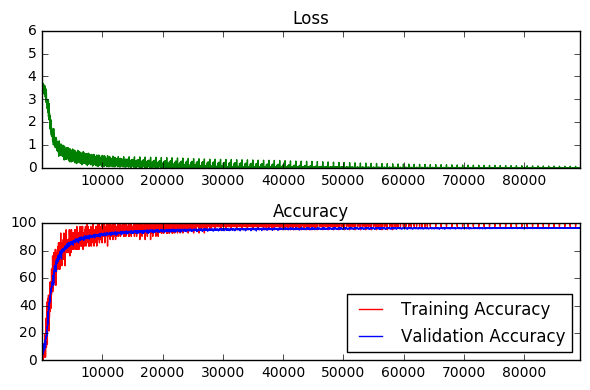

Average Test accuracy: 85.6%


In [20]:
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0, 100])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

print('Average Test accuracy: %.1f%%' % np.mean(test_acc_batch))

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

We have three steps of preprocesssing the data.
1. Greyscale images: Since traffic signs are distinguished based on their shape, we don't have to have RGB. So, we convert images into greyscaled ones.
2. Normalize images: We implement Min-Max scaling in the normalize() function to a range of a=0.1 and b=0.9. Since the traffic sign image data is in greyscale, you'll have to use a max of 255 and min of 0.
3. Turn labels into numbers and apply One-Hot Encoding: Each image in traffic signs has a corresponding label, a number between 0 and 42 representing the reference id as a traffic sign. For the purposes of this tutorial, we're going to want our labels as "one-hot vectors". A one-hot vector is a vector which is 0 in most dimensions, and 1 in a single dimension. In this case, the n-th number will be represented as a vector which is 1 in the n-th dimension.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

We have 39209 training images, from which a portion of images for the validation are randomly selected. The random selection for the validation is important to avoid the skewness of the classification in the training phase. We evaluate the model with the validation images and test it with 12630 testing images.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

Our final architecture is a multilayer convolution network, which consists of two convolutional layers and two hidden layers. 

##### Convolutional Layers
The convolutional will compute 32 features for each 5x5 patch. Its weight tensor will have a shape of [5, 5, 1, 16]. The first two dimensions are the patch size, the next is the number of input channels, and the last is the number of output channels. We will also have a bias vector with a component for each output channel.
To apply the layer, we first reshape feature images to a 4d tensor, with the second and third dimensions corresponding to image width and height, and the final dimension corresponding to the number of color channels.
We then convolve x_image with the weight tensor, add the bias, apply the ReLU function. In order to build a deep network, we stack several layers of this type. The second layer will have 64 features for each 3x3 patch.

##### Fully Connected Layer
Now that the image size has been reduced to 8x8, we add a fully-connected layer with 1024 neurons to allow processing on the entire image. We reshape the tensor from the pooling layer into a batch of vectors, multiply by a weight matrix, add a bias, and apply a ReLU.

##### Readout Layer
Finally, we add a layer, just like for the one layer softmax regression above.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


######  **Answer:**

We use **GradientDescentOptimizer**. GradientDescentOptimizer can be controlled with a **learning_rate** as a paramter. The greater the learning rate, the faster the convergence into the steady state, and yet the more likely to make the error get large. We try out with 0.01, 0.05, and 0.1 of **learning_rate** and pick and choose one that leads to the best evaluation accuracy. 
**epochs** is iterations of running the models. One **epoch** is an iteration of training with the whole training set. **epochs** has an effect on training the model with the entire training set explored repeatedly and thoroughly. So, generally speaking, as the number of epochs increases, the accuracy gets better. However, there is the peak point where the performance is about to get worse reversely. We find it as an optimal point.
**batch_size** is the number of input images that is processed at once. The larger the number, the faster the process as long as the memory can accomodate it. If it is too large, however, the error of "resource exhausted" will be encountered. Our machine has an Intel Pentium CPU 2.5GHz and GeForce GT 730. We find a right number by decreasing it by 2 from 40.

As the result from finding optimal values, we end up having
* learning_rate: 0.01
* epochs: 100
* batch_size: 42

### Question 5


_What approach did you take in coming up with a solution to this problem?_

###### **Answer:**

To improve accuracy, we knobed hyperparameters including epochs, batch_size and learning rate. Our final values of hyperparameters include epochs = 6, batch_size = 16, and learning_rate = 0.05. 

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [21]:
def transform_image(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    return img

In [22]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
#training_file = "traffic-signs-data/train.p"
testing_file = "traffic-signs-data/test.p"

#with open(training_file, mode='rb') as f:
#    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
#X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [23]:
new_dataset = {}
#new_dataset['train_dataset'] = []
#new_dataset['train_labels'] = []
new_dataset['test_dataset'] = []
new_dataset['test_labels'] = []

#tot_len = len(X_train)
#selected_train_keys = np.random.randint(tot_len, size = round(tot_len * 0.1))
#for i in selected_train_keys:
#    for j in range(10):
#        img = transform_image(X_train[i],20,10,5)
#        img = greyscale(img)
#        new_dataset['train_dataset'].append(img)
#        new_dataset['train_labels'].append(y_train[i])

tot_len = len(X_test)
selected_test_keys = np.random.randint(tot_len, size = round(tot_len * 0.1))
for i in selected_test_keys:
    for j in range(10):
        img = transform_image(X_test[i],20,10,5)
        img = greyscale(img)
        new_dataset['test_dataset'].append(img)
        new_dataset['test_labels'].append(y_test[i])
        
print("New dataset generated!")

New dataset generated!


In [24]:
#new_dataset['train_dataset'] = normalize(np.array(new_dataset['train_dataset']))
new_dataset['test_dataset'] = normalize(np.array(new_dataset['test_dataset']))
#new_train_dataset = new_dataset['train_dataset'].astype(np.float32)
new_test_dataset = new_dataset['test_dataset'].astype(np.float32)
print('New dataset preprocessed')

New dataset preprocessed


In [25]:
#new_dataset['train_labels'] = encoder.transform(np.array(new_dataset['train_labels']))
new_dataset['test_labels'] = encoder.transform(np.array(new_dataset['test_labels']))
# Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
#new_train_labels = new_dataset['train_labels'].astype(np.float32)
new_test_labels = new_dataset['test_labels'].astype(np.float32)

print('New labels One-Hot Encoded')

New labels One-Hot Encoded


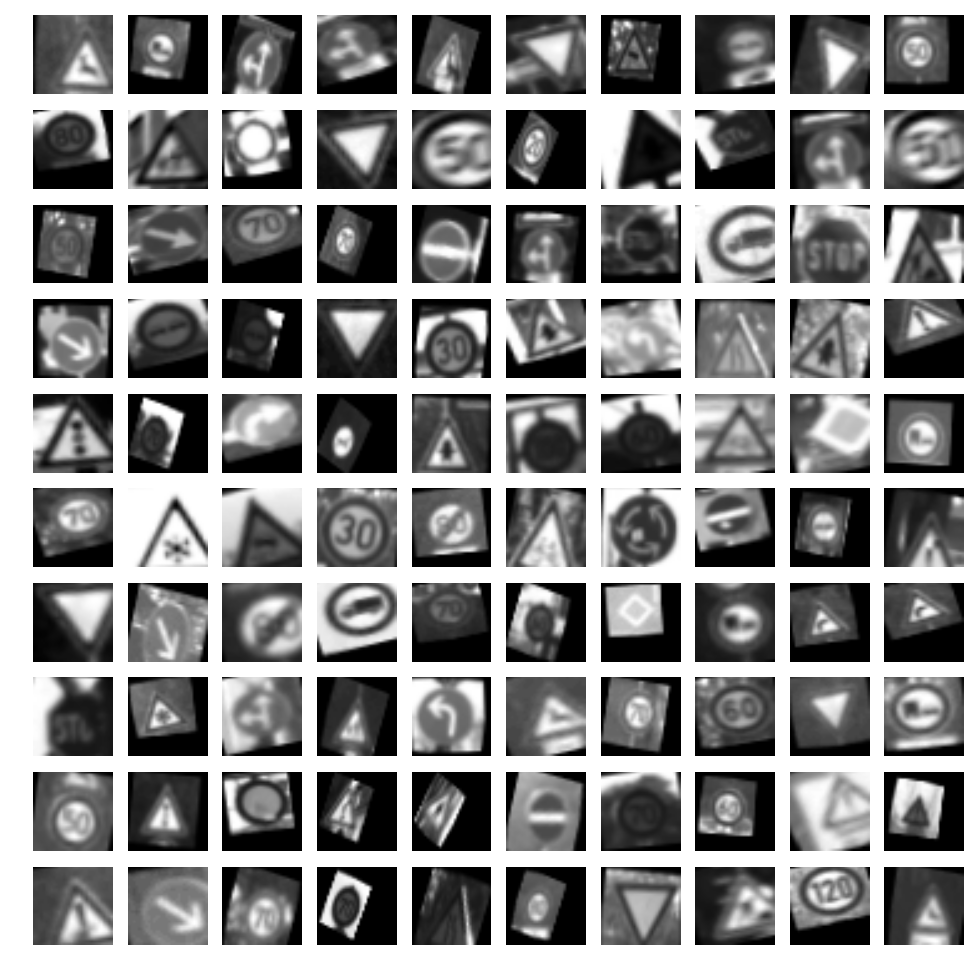

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

gs1 = gridspec.GridSpec(10, 10)
gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 
plt.figure(figsize=(12,12))
d = round(len(new_test_dataset)/100)
for i in range(100):
    ax1 = plt.subplot(gs1[i])
    #ax1.set_xticklabels([])
    #ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    plt.subplot(10,10,i+1)
    plt.imshow(new_test_dataset[i*d], cmap='gray')
    plt.axis('off')

plt.show()

In [27]:
new_test_dataset, new_test_labels = reformat(new_test_dataset, new_test_labels)
print('Shape: test_dataset = %s, test_labels = %s '%(new_test_dataset.shape, new_test_labels.shape))

Shape: test_dataset = (12630, 32, 32, 1), test_labels = (12630, 43) 


In [28]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

# 1. Read signnames
import csv
tsId = []
with open('signnames.csv') as file:
    reader = csv.reader(file, delimiter='\n') 
    next(reader)
    for row in reader:
        c= row[0].split(',')
        tsId.append(c[1])
    file.close()
print(tsId)

['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No passing for vechiles over 3.5 metric tons', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vechiles', 'Vechiles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End of no passing by vechiles over 3.5 metric tons']


In [29]:
# hyperparamters
batch_size = 42
patch_size = 5
depth = 16
num_hidden = 64
epochs = 101

In [30]:
log_batch_step = 1000
batches = []
test_acc_batch = []
top5_prob = []
top5_cls = []
sm_prob = []
sm_true = []

topfive=tf.nn.top_k(test_prediction, k=5, sorted=True, name=None)
with tf.Session(graph=graph) as sess:
    sess.run(init)
    print('Initialized')
    
    # [Save&Restore:begin]
    # restore all variables
    ckpt = tf.train.get_checkpoint_state(ckpt_dir)
    if ckpt and ckpt.model_checkpoint_path:
        print(ckpt.model_checkpoint_path)
        saver.restore(sess, ckpt.model_checkpoint_path)
    # [Save&Restore:end]

    batch_count = int(math.floor(len(new_test_dataset)/batch_size))
    # The test cycle
    for batch_i in range(batch_count):#batches_pbar:
        offset = (batch_i * batch_size)
        batch_data = new_test_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = new_test_labels[offset:(offset + batch_size), :]
        predictions = sess.run(test_prediction, {tf_test_dataset : batch_data})
        test_accuracy = accuracy(predictions, batch_labels)
        test_acc_batch.append(test_accuracy)
        if test_accuracy > 20:
            #top5_prob, top5_cls = sess.run(topfive, {tf_test_dataset : batch_data})
            sm_prob.append(predictions[0])
            sm_true.append(batch_labels[0])
    print('Test Accuracy: %.1f' % np.mean(test_acc_batch))

Initialized
./ckpt_dir\model.ckpt-99
Test Accuracy: 16.1


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**
We tried to make a new dataset by googling images in the Internet. However, we encountered the difficulty in extracting regions of interest from images. So, we decided to use [the techniques](https://carnd-udacity.atlassian.net/wiki/questions/10322627/answers/12618461) presented on the discussion board of Confluence. That is, one way to collect more data is to take the picture of the same sign by applying affine transformations, such as rotations, translations and shearing.

We randomly pick and choose 10% of the test dataset and then make 10 jittered images for each, ending up having 12630 images that the model has never seen before. As the result from the testing, we end up with 16.1% accuracy on the test dataset. 

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

Definitely it can be as long as my model is trained with similar images.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

The model is somewhat uncertain of some images, which turns out to fall into two classes. As can be seen in the following figure, the probability of the first choice is almost equal to that of the second.

[0] (1st) Traffic signals, (2nd) Speed limit (30km/h)
[1] (1st) Yield, (2nd) Keep left
[2] (1st) Priority road, (2nd) Roundabout mandatory
[3] (1st) Traffic signals, (2nd) General caution
[4] (1st) Keep left, (2nd) General caution


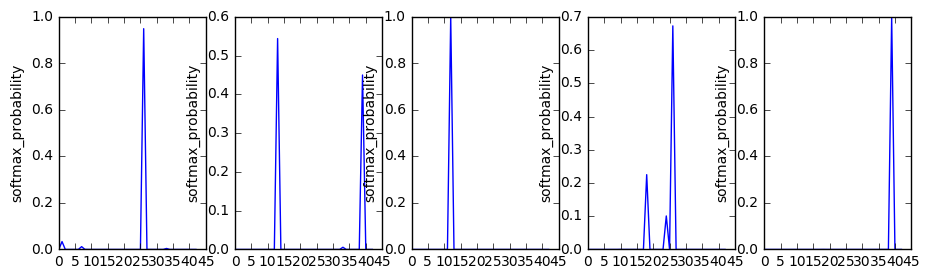

In [31]:
import copy
plt.figure(figsize=(11,3))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.plot(sm_prob[i*11])
    plt.ylabel('softmax_probability')
    tmp = copy.copy(sm_prob[i*11])
    n1 = np.argmax(tmp)
    tmp[n1] = 0
    n2 = np.argmax(tmp)
    print("[%d] (1st) %s, (2nd) %s"%(i, tsId[n1], tsId[n2]))
plt.show()

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.